In [1]:
import cmocean
import numpy as np
import xarray as xr
from scipy import fft
from scipy import signal
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from thermal.plotting import make_colorbar

plt.rcParams['text.usetex'] = True

In [2]:
zarr_path = '../result/crmpt12/PeriodicSurges_Timeseries_9ka.zarr'

In [3]:
# open the full timeseries and load into memory
src = xr.open_zarr(zarr_path).compute()
# compute the annual rolling mean
src = src.rolling(t=10, min_periods=1).mean('t')
# downsample to annual timesteps 
src = src.interp(t=np.linspace(0.0, 9e3, 90_00, endpoint=False),
                 method="linear",
                 kwargs={"fill_value": "extrapolate"})
# flip the beta values so they are decending
src = src.sortby('beta', ascending=False)

In [4]:
src.beta[-3]

<xarray.DataArray 'beta' ()>
array(0.0001778)
Coordinates:
    beta     float64 0.0001778

In [5]:
_, norm, s_map, bounds = make_colorbar(-np.log(np.logspace(-3, -4, 9)))
#overwrite the colormap wiht a cmocean colormap
cmap = cmocean.cm.thermal

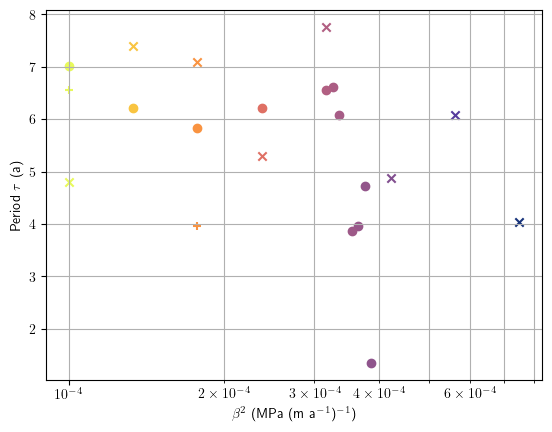

In [6]:
fig, ax = plt.subplots()


markers = ['x', 'o', '+']
for i, SP in enumerate(src.SP): 
    for beta in src.beta: 
        
        color = cmap(norm(-np.log(beta)))
    
        # subset of larger timeseries
        sub = src.sel(SP=SP, beta=beta)

        x = sub['percent_temperate'].isel(t=slice(2500, 4500)).values
        t = sub['percent_temperate'].isel(t=slice(2500, 4500)).t.values
        # lenght of timeseries 
        nt = (t[-1] - t[0])
        
        # ax.plot(t,x)
        # Number of sample points
        N = t.shape[0]
        # sample spacing
        T = t[1] - t[0]
        # mean of timeseries
        mu = np.mean(x)
        # compute real fft of normalized timeseries
        yf = fft.rfft(x - mu)
        # compute the requency range of the real fft
        xf = fft.rfftfreq(N, T)
        # create an empty fourier coeffiecents vector
        tsfit2dft = np.zeros_like(yf)
        # sort the real part of the fourier coeffiecents
        # in descending order. Need [::-1] (to reverse)
        # since numpy only sorts ascendingly 
        I = np.argsort(np.absolute(yf))[::-1]
        
        # compute the period from the frequnecy 
        z = 1 / xf[I[0]]
        # compute the amplitude 
        # Normalize the amplitude by number of bins and multiply by 2
        # because we removed second half of spectrum above the Nyqist frequency 
        # and energy must be preserved
        p = 2 / N * np.absolute(yf)[I[0]]
        
        #
        if ((z <= 100) | (z-1==nt) | (p<=0.5)):
            z=np.nan
            p=np.nan
                
        ax.scatter(beta, p, color=color, marker=markers[i])
    

# ax.scatter(src.beta, (src.beta * 0) + 50)
# ax.set_ylim(None, 425)
# ax.set_xlim(0, 5)

ax.grid(which='both', axis='both')
ax.set_xscale('log')

ax.set_ylabel(r'Period $\tau$ (a)')
ax.set_xlabel(r"$\beta^2$ (MPa (m a$^{-1}$)$^{-1}$)")

fig.savefig('spectral_2.5--4.5ka_amp.png', dpi=400)

Text(0.5, 0, '$\\beta^2$ (MPa (m a$^{-1}$)$^{-1}$)')

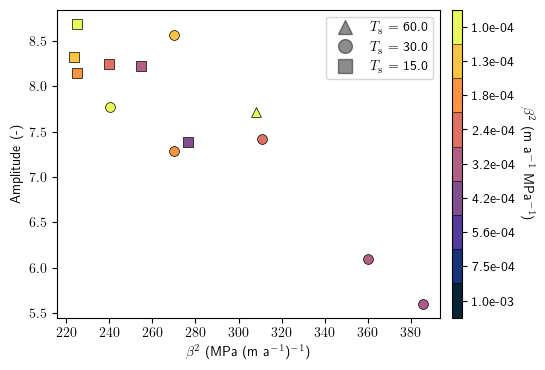

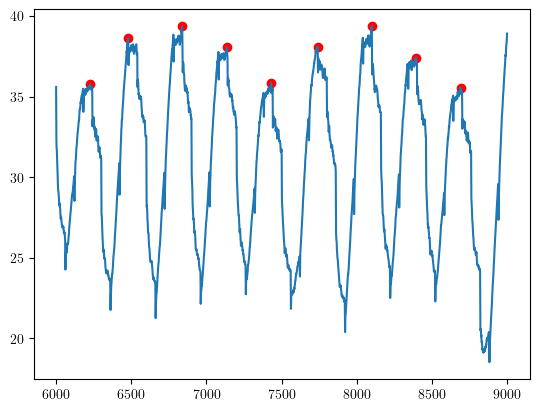

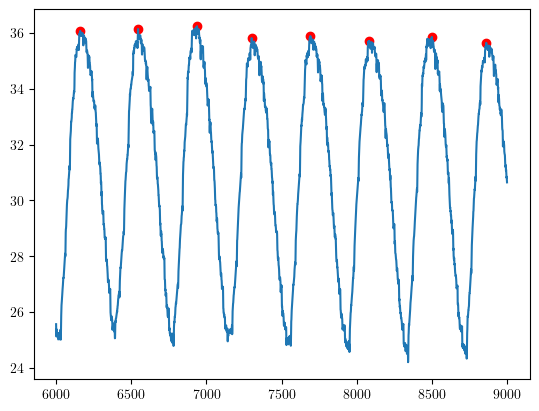

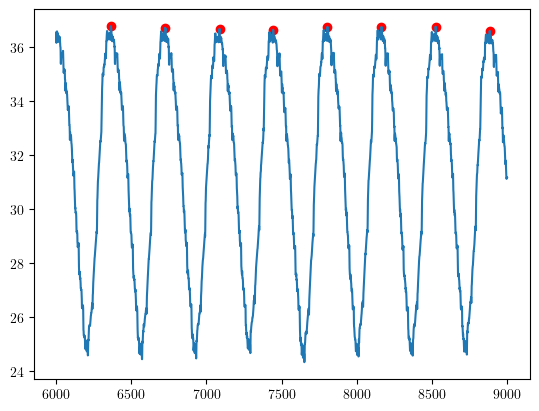

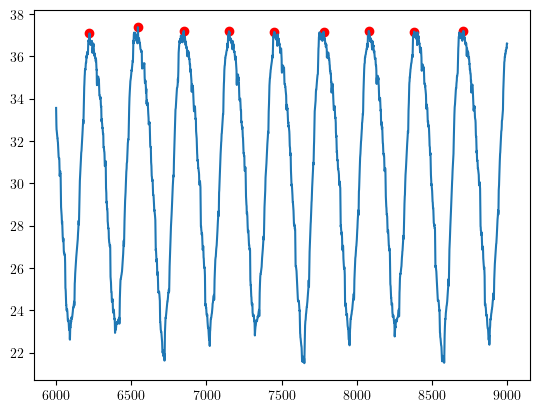

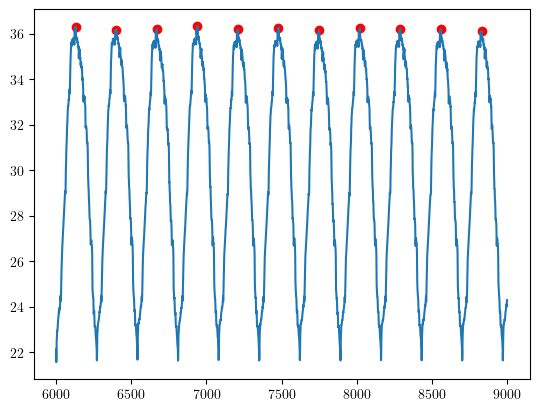

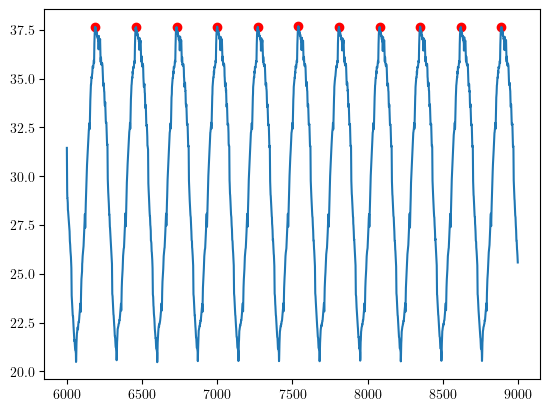

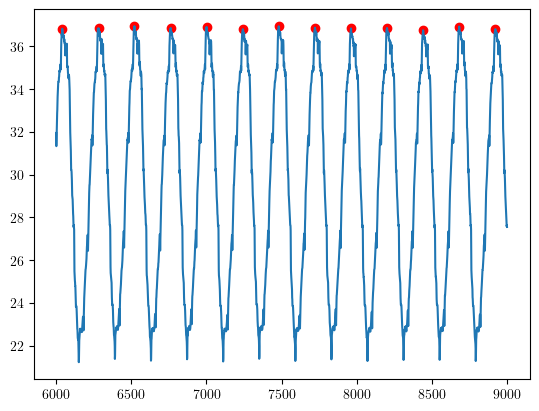

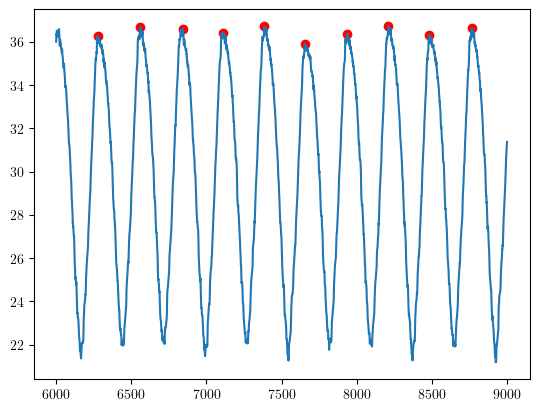

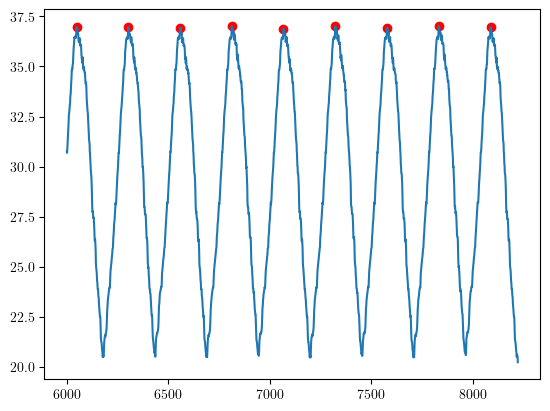

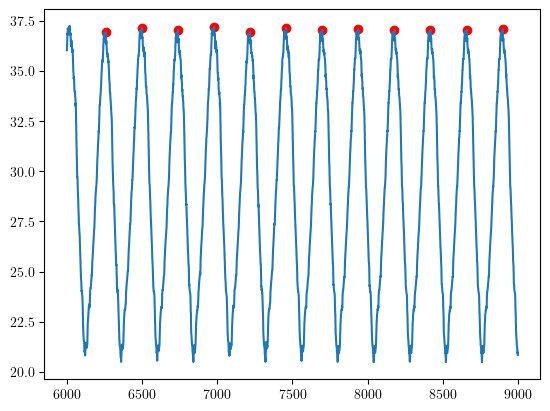

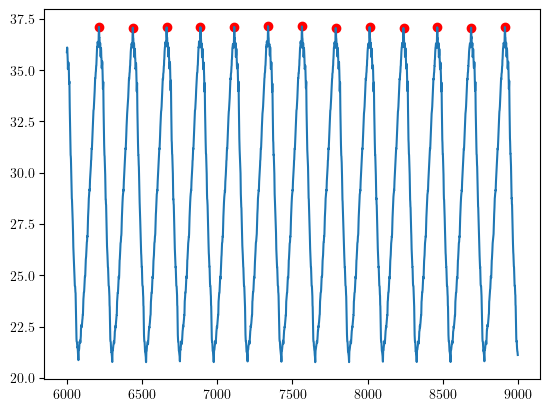

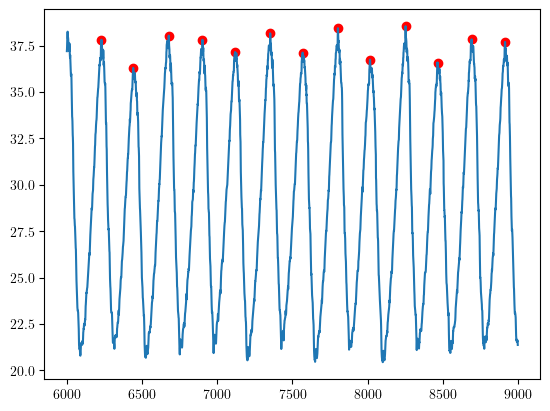

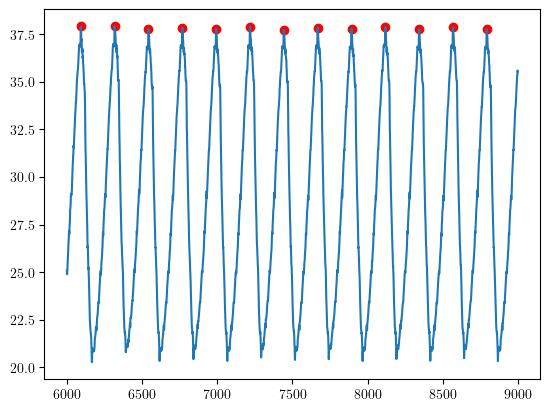

In [7]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(6,4))
# ax.grid(which='both', axis='both', zorder=-1)

markers = ['^', 'o', 's']
legend_elements = []
for i, SP in enumerate(src.SP[::-1]): 
    for beta in src.beta:
        
        color = cmap(norm(-np.log(beta)))
    
        # subset of larger timeseries
        sub = src.sel(SP=SP, beta=beta).isel(t=slice(6000, 9000))
                
        t = sub.t.values
        x = sub['percent_temperate'].values

        idx, _ = signal.find_peaks(x, distance=100, prominence=3)
        
        if idx.size <= 2: 
            tau = np.nan
            amp = np.array([np.nan])
            contour_heights = np.array([np.nan])
            
        else:
            tau = np.diff(t[idx]).mean()  
            
            fig1, ax1 = plt.subplots()
            ax1.plot(t,x)

            ax1.scatter(t[idx],x[idx], color='r')
            
#             t_ip1 = np.array(((t[idx][:-1] + np.diff(t[idx])/4) - 2500), dtype=int)
#             t_im1 = np.array((( t[idx][1:] - np.diff(t[idx])/4) - 2500), dtype=int)
            
            
#             ax1.scatter(t[t_ip1],x[t_ip1], color='r', marker='x')
#             ax1.scatter(t[t_im1],x[t_im1], color='r', marker='x')

            
            # edge ampltiudes will be incorrect if with, edge peaks are within 
            # half a period of the boundaries
            check = lambda t, idx, tau, index: np.abs(t[idx[index]] - t[index]) < tau/2

            if check(t, idx, tau, 0) & check(t, idx, tau, -1): 
                idx = idx[1:-1]
            elif check(t, idx, tau, 0): 
                idx = idx[1:]
            elif check(t, idx, tau, -1):
                idx = idx[:-1]
            
            amp = signal.peak_prominences(x, idx)[0]

            contour_heights = x[idx] - amp

            # ax1.vlines(x=t[idx], ymin=x[idx] - amp/2, ymax=x[idx])
            # ax1.axhline((x[idx] - amp/2).mean())
            # ax1.axhline(x.mean(), ls =':', lw=1.0, c='k')

            
        ax.scatter(tau, amp.mean()/2, color=color, marker=markers[i], edgecolors='k', linewidths=0.5, s=50, zorder=10)
        
        
        # ax.errorbar(tau, amp.mean()/2, amp.std(), 
        #        linestyle='none', c='k', lw=1., zorder=-1, alpha=0.5, capsize=0.0)
            
         # amp.mean()/2 
        
    legend_elements.append(Line2D([0], [0], marker=markers[i], color='w', markerfacecolor='k', 
                                  alpha=0.45, markeredgecolor='k',
                                  label=r'$T_{{\rm s}}$ = {}'.format(float(SP)), markersize=10))
# # ax.axvline(7.499e-4)
# ax.set_xlim(9.4e-5, 1e-3)
# # ax.set_ylim(5, None)
# ax.grid(which='both')
# ##########################################
# # https://stackoverflow.com/a/44079725
# ###########################################
# ax.set_xscale('log')
# x_major = ticker.LogLocator(base = 10.0, numticks = 2.5)
# ax.xaxis.set_major_locator(x_major)

# x_minor = ticker.LogLocator(base=10.0, subs=np.logspace(-1,0,9)[1:-1], numticks=16)
# ax.xaxis.set_minor_locator(x_minor)
# ax.xaxis.set_minor_formatter(ticker.NullFormatter())

# # FuncFormatter can be used as a decorator
# @ticker.FuncFormatter
# def minor_formatter(x, pos):
#     return f'${x:1.2e}$'
# ax.xaxis.set_minor_formatter(minor_formatter)

s_map = cm.ScalarMappable(norm=norm, cmap=cmap,)
s_map.set_array(-np.log(np.logspace(-3,-4,9)))

cbar = fig.colorbar(s_map, 
                    ax=ax, 
                    norm=norm, 
                    aspect=30,
                    pad=0.025,
                    spacing='proportional',
                    ticks=-np.log(np.logspace(-3,-4,9)), 
                    boundaries=bounds,
                    drawedges=True,
                    )

cbar.set_ticklabels(map(lambda x: f'{x:1.1e}', np.logspace(-3,-4,9)))
cbar.set_label(r"$\beta^2$ (m a$^{-1}$ MPa$^{-1}$)", rotation=270, labelpad=15)


ax.legend(handles=legend_elements)

ax.set_ylabel('Amplitude (-)')
# ax.set_xlabel('Period (a)' )

ax.set_xlabel(r"$\beta^2$ (MPa (m a$^{-1}$)$^{-1}$)")

# fig.savefig('spectral_2.5--4.5ka_amplitude.png', dpi=400)

In [ ]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(6,4))
ax.grid(which='both', axis='both', zorder=-1)

markers = ['^', 'o', 's']
legend_elements = []
for i, SP in enumerate(src.SP[::-1]): 
    for beta in src.beta:
        
        color = cmap(norm(-np.log(beta)))
    
        # subset of larger timeseries
        sub = src.sel(SP=SP, beta=beta)
        
        sub['u_ELA'] = sub.flux_across_ELA / sub.h_ELA
        
        ax.scatter(sub.relative_volume.mean(), sub.u_ELA.mean(), color=color, marker=markers[i], edgecolors='k', linewidths=0.5, s=50, zorder=10)
        
        
# ax.set_xscale('log')


In [ ]:
fig, ax = plt.subplots(3,1, sharex=True, sharey=True,
                       constrained_layout=True)

marker_colors = ['r', 'k']
line_colors = ['tab:blue', 'tab:orange']
legend_elements = []
for i, SP in enumerate(src.SP[::-1]):         
    for j, beta in enumerate(src.beta[-3:-1]): 
    
        color = cmap(norm(-np.log(beta)))
    
        # subset of larger timeseries
        sub = src.sel(SP=SP, beta=beta)

        x = sub['percent_temperate'].isel(t=slice(2500, 4500)).values
        t = sub['mean_enthalpy'].isel(t=slice(2500, 4500)).t.values
        
        idx, _ = signal.find_peaks(x, distance=100, prominence=3)
                
        if idx.size == 0: 
            tau = np.nan
            amp = np.nan
            contour_heights = np.array([np.nan])
        else:
            tau = np.diff(t[idx]).mean()  
            
            ax[i].plot(t,x, alpha=0.65)
            ax[i].scatter(t[idx],x[idx], color=marker_colors[j], alpha=0.75)
            
            
            # edge ampltiudes will be incorrect if with, edge peaks are within 
            # half a period of the boundaries
            check = lambda t, idx, tau, index: np.abs(t[idx[index]] - t[index]) < tau/2

            if check(t, idx, tau, 0) & check(t, idx, tau, -1): 
                idx = idx[1:-1]
            elif check(t, idx, tau, 0): 
                idx = idx[1:]
            elif check(t, idx, tau, -1):
                idx = idx[:-1]

            amp = signal.peak_prominences(x, idx)[0]

            contour_heights = x[idx] - amp

            # ax.vlines(x=t[idx], ymin=contour_heights, ymax=x[idx])
            
            if i == 0: 
                legend_elements.append(Line2D([0], [0], color=line_colors[j],
                                              label=r'$\beta^2$ = {:1.1e}'.format(float(beta))))
                
    ax[i].text(2675,19.5, r'$T_{{\rm s}}$ = {:2.0f} (a)'.format(float(SP)),
               ha='center', va='center')
    
    ax[i].set_ylabel('$FT$ (-)')
    
ax[0].legend(handles =legend_elements, fontsize='small', loc='lower right')
ax[i].set_xlabel('Time (a)')

fig.savefig('constant_periods.png', dpi=300)

In [ ]:
dV_mu = src.isel(t=slice(2000,4500)).relative_volume.mean('t') - 1
dT_mu = src.isel(t=slice(2000,4500)).percent_temperate.mean('t') - 54.72
dH_mu = src.isel(t=slice(2000,4500)).mean_enthalpy.mean('t') - 133.27

Q_mu = src.isel(t=slice(2000,4500)).flux_across_ELA.mean('t')
# dV_std = src.isel(t=slice(2000,4500)).relative_volume.std('t')

In [ ]:
fig, ax = plt.subplots(3,1, sharex=True, constrained_layout=True, 
                       figsize=(6.5,9))

markers = ['x', 'o', '+']

for i, SP in enumerate(dV_mu.SP): 
    # ax.errorbar(dV_mu.beta, dV_mu.sel(SP=SP), dV_std.sel(SP=SP), linestyle="None", color='k')

    ax[0].scatter(dV_mu.beta, dV_mu.sel(SP=SP), 
               c=norm(-np.log(dV_mu.beta)), cmap=cmap,
               marker=markers[i], label=r'$T_{\rm s}$ = ' + str(int(SP)))
    

    ax[1].scatter(dT_mu.beta, dT_mu.sel(SP=SP), 
               c=norm(-np.log(dT_mu.beta)), cmap=cmap,
               marker=markers[i], label=r'$T_{\rm s}$ = ' + str(int(SP)))

    ax[2].scatter(dH_mu.beta, dH_mu.sel(SP=SP), 
               c=norm(-np.log(dH_mu.beta)), cmap=cmap,
               marker=markers[i], label=r'$T_{\rm s}$ = ' + str(int(SP)))
# ax.grid()
ax[2].legend()
ax[1].set_xscale('log')
# ax.set_ylabel('

In [ ]:
f = src.isel(t=slice(2000,4500)).where(lambda x: x.u_bar_bed >= 1.0).flux_across_ELA

Q_mu = f.mean('t')
Q_std = f.std('t')
# Q_mu = src.isel(t=slice(2000,4500)).flux_across_ELA.mean('t')

markers = ['x', 'o', '+']

fig, ax = plt.subplots(1,1, sharex=True, sharey=True)
for i, SP in enumerate(dV_mu.SP[-1:]): 
    ax.errorbar(Q_mu.beta, Q_mu.sel(SP=SP), Q_std.sel(SP=SP), 
                   linestyle='none', c='k', lw=1., zorder=-1, alpha=0.5, capsize=0.0)
    ax.scatter(Q_mu.beta, Q_mu.sel(SP=SP), 
               c=norm(-np.log(dT_mu.beta)), cmap=cmap,
               marker=markers[i], label=r'$T_{\rm s}$ = ' + str(int(SP)))
    
    
ax.legend()
plt.xscale('log')
# plt.yscale('log')


In [ ]:
Q_mu = src.isel(t=slice(2000,4500)).where(lambda x: x.u_bar_bed <= 1.0).flux_across_ELA.mean('t')


In [ ]:
src.isel(t=slice(2000,4500)).sel(SP=60).isel(beta=slice(0,-1)).flux_across_ELA.plot(x='t',hue='beta')
# f.sel(SP=60).isel(beta=slice(-3,None)).plot(x='t',hue='beta');

In [ ]:
src = xr.open_zarr(zarr_path).compute()

y = np.arange(0.1, 2.0, 0.1)[None,:]
x = np.arange(0, 6e3, 60)[:, None]

t = (x + y).flatten()

In [ ]:
f = src.sel(SP=60).sel(t=slice(2000,4500)).isel(beta=slice(2,3))

# f.u_bar_surface.plot(x='t',hue='beta');

(f.flux_across_ELA / 100).plot(x='t',hue='beta');
# f.where(f.u_bar_bed >= 0.1).flux_across_ELA.plot(x='t',hue='beta');
f.sel(t=t, method='nearest').flux_across_ELA.plot(x='t',hue='beta');

# plt.xlim(3e3, 3.5e3)
# plt.yscale('log')

In [ ]:
f.flux_across_ELA / 100